# Final Capstone - Machine Learning pipeline for image generation

## About [VQGAN](https://github.com/CompVis/taming-transformers)

Full description of the architecture can be found [here](https://compvis.github.io/taming-transformers/paper/paper.pdf).

## About [CLIP](https://github.com/openai/CLIP) 

Full description of the architecture can be found [here](https://arxiv.org/pdf/2103.00020.pdf).


Notebook adapted from the [work](https://colab.research.google.com/drive/1L8oL-vLJXVcRzCFbPwOoMkPKJ8-aYdPN#scrollTo=CppIQlPhhwhs&uniqifier=1) of Katherine Crowson.

## Installation and loading of required libraries

In [ ]:
#Get models from repositories referenced above
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning einops transformers
!pip install -e ./taming-transformers

import argparse
import math
from pathlib import Path
import sys
sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
import requests

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

from taming.models import cond_transformer, vqgan
from CLIP import clip

Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 8.20 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 1335 (delta 58), reused 481 (delta 30), pack-reused 810
Receiving objects: 100% (1335/1335), 412.35 MiB | 39.74 MiB/s, done.
Resolving deltas: 100% (267/267), done.
     |████████████████████████████████| 53 kB 1.1 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 582 kB 51.2 MB/s 
     |████████████████████████████████| 3.8 MB 54.0 MB/s 
     |████████████████████████████████| 112 kB 54.1 MB/s 
     |████████████████████████

Obtaining file:///content/taming-transformers
  Running setup.py develop for taming-transformers


## Download of ImageNet models for training of VQGAN

In [ ]:
#ImageNet 1024
!curl -L 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_1024.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_1024.ckpt
#ImageNet 16384
# !curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
# !curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   645  100   645    0     0   1020      0 --:--:-- --:--:-- --:--:--  1020
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  913M  100  913M    0     0  14.8M      0  0:01:01  0:01:01 --:--:-- 14.9M


## Definition of classes and functions

In [ ]:
def sinc(x):
    #print('sinc')
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    #print('lanczos')
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    #print('ramp')
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    #print('resample')
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        #print('Replace-for')
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        #print('Replace-bac')
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


#Post-process generated image --> decoding
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        #print('Clamp-for')
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        #print('Clamp-bac')
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply

#Generates and encodes image from input using VQGAN ??
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        #print('Prompt-init')
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        #print('Prompt-for')
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()


#Gets data from VQGAN ready for encoding with CLIP (Image->text)
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        #print('Makecut-init')
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        #print('Makecut-forw')
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        return clamp_with_grad(torch.cat(cutouts, dim=0), 0, 1)


#Load VQGAN model for image generation
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


####

def synth(z): ###
    #Generate, encode, and quaitize image with VQGAN model (quantize)
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1) #(x,codebook)
    #post-process generated image (decode)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1) #returns decoded image

@torch.no_grad()
def checkin(i, losses): ### Visualize (print) image if turn
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    display.display(display.Image('progress.png'))


#formulates the loss terms for optimization
def ascend_txt(): ###
    #Generate image with VQGAN model (using vectors)
    out = synth(z)

    #Get image features with CLIP (from image to text)
    ##Given a batch of images, returns the image features encoded by the vision portion of the CLIP model.
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    result = []

    if args.init_weight: #computes symmetric loss function
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)


    result.append(pMs(iii))

    return result #returns computed loss value

loss_evol = [] #keep track of loss during training
def train(i):
    opt.zero_grad() #set gradient to zero
    lossAll = ascend_txt() #encode image
    if i % args.display_freq == 0:
        checkin(i, lossAll) #print image if turn 
    loss = sum(lossAll) #sum of loss
    loss_evol.append(loss.item())
    loss.backward() #computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
    opt.step() #causes the optimizer to take a step based on the gradients of the parameters.
    with torch.no_grad(): #reduce memory consumption for computations 
        z.copy_(z.maximum(z_min).minimum(z_max))


## Definition of parameters

In [ ]:
args = argparse.Namespace(
    prompt=['coral reef'],
    max_iterations = 1001,
    size=[720,720],
    init_weight=0.,
    step_size=0.05,
    cutn=64,
    cut_pow=1.,
    display_freq=250,
    seed=0
)

## Set up of run

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#define VQGAN model and training set
model = load_vqgan_model('vqgan_imagenet_f16_1024.yaml', 'vqgan_imagenet_f16_1024.ckpt').to(device)
#load pre-trained CLIP model
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)

cut_size = perceptor.visual.input_resolution
e_dim = model.quantize.e_dim
f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
n_toks = model.quantize.n_e
toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

######

one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
z = one_hot @ model.quantize.embedding.weight
z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size) # optimization algorithm that can be used instead of the 
#classical stochastic gradient descent procedure to update network weights iterative based in training data.

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

#encode input text with CLIP
txt, weight, stop =  args.prompt, 1.0, float('-inf') #weight n stop??
embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
pMs = Prompt(embed, weight, stop).to(device)

###

Using device: cpu
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 488kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_1024.ckpt


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 66.3MiB/s]


## Run pipeline

In [ ]:
i = 0
try:
    with tqdm() as pbar: #show progress bar
        for i in range(args.max_iterations+1):
            train(i) #takes a step in training
            i += 1 #only to keep track of images to download
            pbar.update() #update progress bar 
except KeyboardInterrupt: #stop iteration upon request
    pass

0it [00:00, ?it/s]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

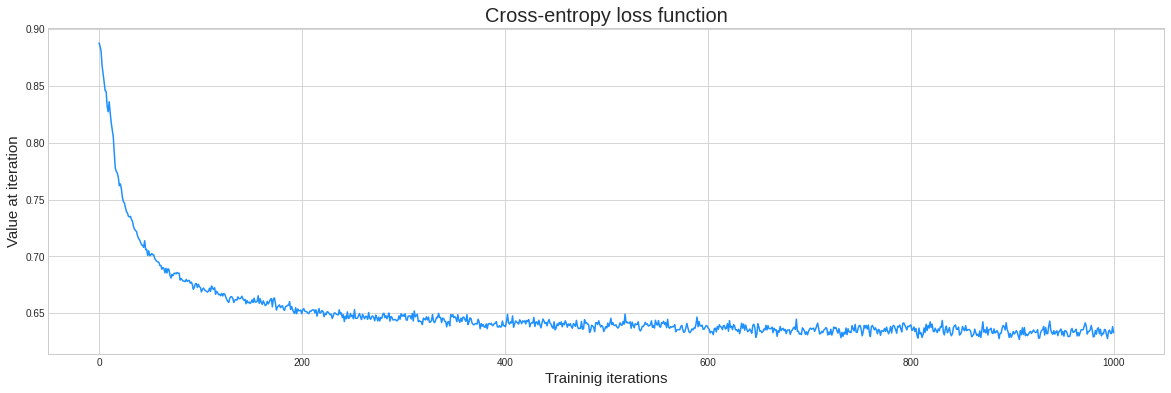

In [ ]:


x = np.linspace(0, 1000, 1002)
plt.figure(figsize=(20,6))
plt.plot(x, loss_evol,color='dodgerblue')
plt.title("Cross-entropy loss function", fontsize=20)
plt.xlabel("Traininig iterations", fontsize=15)
plt.ylabel("Value at iteration", fontsize=15);
